# 프로젝트: 뉴스기사 요약해보기

### [루브릭]
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
    - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.


2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
    - 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
    
    
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
    - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

### [학습과정]
1. 데이터 수집하기
2. 데이터 전처리하기(추상적 요약)
3. 어텐션 메커니즘 사용하기 (추상적 요약)
4. 실제 결과와 요약문 비교하기 (추상적 요약)
5. Summa을 이용해서 추출적 요약해보기

### [결과 및 회고]

## 1. 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
35196,"NYT, New Yorker win Pulitzer for reporting abu...",The New York Times and The New Yorker magazine...
48454,Army carried snow for 1964 Winter Olympics due...,After the 1964 Innsbruck Winter Olympics were ...
75042,Jio may offer part refund for 'JioPhone' befor...,"According to reports, Reliance Jio may offer i..."
74550,Taylor Swift deletes all posts from social med...,Singer Taylor Swift has removed all posts from...
54448,Private sector can run airlines better than go...,Union Minister Jayant Sinha has said the priva...
16448,Indian-origin man held for racist comments aga...,"Kessie Nair, a former Indian-origin Councillor..."
34746,I'm being framed: Jailed doctor on Gorakhpur h...,"Dr Kafeel Khan, who is in jail in connection w..."
16436,Shastri was batting when cricket's 2nd tied Te...,India's former cricketer and current coach Rav...
96709,Flipper taught by Warne got me Warner's wicket...,"Indian spinner Kuldeep Yadav, who registered 4..."
8815,Life's over: Mumbai businessman texted friends...,"Ashwin Lalit Jain, a 40-year-old gold business..."


In [4]:
len(data)

98401

우리는 text 시퀀스를 입력받으면 headlines를 예측하도록 신경망을 훈련시키려고 합니다.

## 2. 데이터 전처리하기

우선, 유니크한 데이터가 몇개있는지 확인해봅니다.

In [5]:
print('headlines의 유니크한 데이터 수 : ', data['headlines'].nunique())
print('text의 유니크한 데이터 수 : ', data['text'].nunique())

headlines의 유니크한 데이터 수 :  98280
text의 유니크한 데이터 수 :  98360


headline의 유니크한 데이터가 text보다 약 100여개 더 많습니다. text가 달라도 헤드라인이 같은 경우가 있으나 text가 중복된 경우는 본문 자체가 동일하다는 뜻이므로 중복 샘플을 제거해줍니다.

In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


텍스트 정규화와 불용어 제거

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()    # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text   # <> 등 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (~~) 제거
    sentence = re.sub('""', '', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거. Her's => Her
    sentence = re.sub("[^a-zA-Z]", " ", sentence)   # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)   # m이 3개 이상이면 2개로 변경 ummmm 이런거
    
    # 불용어 제거 (in text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # 불용어 미제거 (in headlines) 제거하면 오히려 어색함
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
    

In [11]:
# 전처리 전후 결과 확인하기 위한 임의의 데이터 호출

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headline, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [12]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [13]:
clean_headline = []

# 전체 Summary 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s, False))

clean_headline[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.097763318422125
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.29956283041887


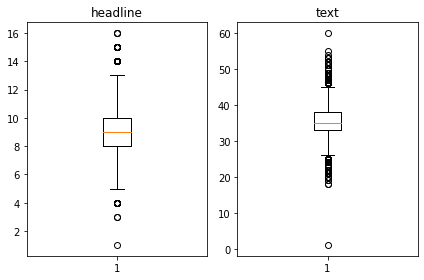

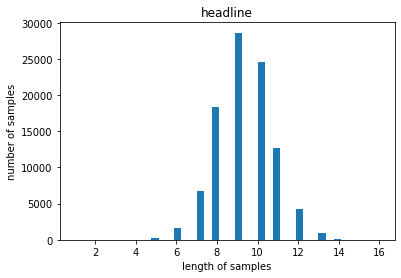

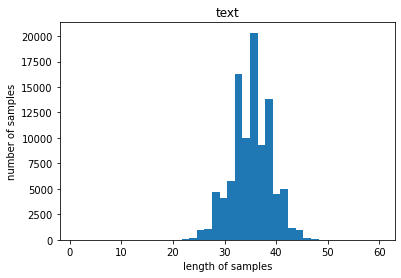

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
text_max_len = 38
headline_max_len = 11

In [18]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
    

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8164497763318422
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 75765


시작 토큰과 종료 토큰 추가하기

In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가.

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


In [22]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [23]:
# 훈련 데이터 테스트 데이터 분리

indices = np.arange(encoder_input.shape[0])  # encoder_input과 크기와 형태가 같은 정수 시퀀스 생성
np.random.shuffle(indices)                   # 순서를 랜덤하게 섞어줍니다
print(indices) # 랜덤한 정수 시퀀스 생성!

[18975 59993 74647 ... 69328 48561 21812]


In [24]:
# 샘플 순서를 랜덤 시퀀스를 이용해서 정의해줌

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
# 8:2로 훈련셋 테스트셋 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15153


In [26]:
# 테스트 데이터의 갯수를 이용해 전체 데이터를 양분해줌

encoder_input_train = encoder_input[:-n_of_val] # 뒤로 n_of_val개 빼고 나머지
decoder_input_train = decoder_input[:-n_of_val] 
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] # 앞에 n_of_val개 빼고 나머지
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 : ', len(encoder_input_train))
print('훈련 레이블의 개수 : ', len(decoder_input_train))
print('테스트 데이터의 개수 : ', len(encoder_input_test))
print('테스트 데이터의 개수 : ', len(decoder_input_test))

훈련 데이터의 개수 :  60612
훈련 레이블의 개수 :  60612
테스트 데이터의 개수 :  15153
테스트 데이터의 개수 :  15153


단어 집합 만들기 & 정수 인코딩

In [27]:
src_tokenizer = Tokenizer()    # 토크나이저 생성 - 입력된 훈련 데이터로부터 단어집합 생성 가능하게 해줌
src_tokenizer.fit_on_texts(encoder_input_train)       # 입력된 데이터로부터 단어 집합 생성

In [28]:
# 단어집합이 생성되었고, 각 단어에 고유한 정수가 부여됨. 
# 빈도수 낮은 단어들은 훈련데이터에서 제거

In [29]:
threshold = 8
total_count = len(src_tokenizer.word_index)      # 단어의 수
rare_count = 0             # 등장 빈도수가 threshold보다 작은 단어의 개수를 count
total_freq = 0             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0              # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold) :
        rare_count = rare_count + 1
        rare_freq = rare_freq + value
        
print('단어 집합의 크기 : ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_count - rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 :  60335
등장 빈도가 7번 이하인 희귀 단어의 수: 42569
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 17766
단어 집합에서 희귀 단어의 비율: 70.55440457445927
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.535666591529053


In [30]:
src_vocab = 17500
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 17,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[26, 17, 55, 970, 309, 21, 10509, 2129, 1489, 122, 54, 4692, 1407, 397, 689, 2389, 67, 380, 473, 887, 1106, 463, 763, 4692, 5892, 4692, 1985, 206, 460, 4832, 4638, 561, 1071, 460, 8732], [671, 373, 2667, 3521, 2240, 113, 908, 417, 6033, 577, 58, 1201, 258, 9425, 429, 4833, 72, 408, 3455, 402, 1116, 8948, 6, 1201, 69, 130, 5654, 293], [4582, 324, 594, 980, 3145, 175, 1232, 12501, 133, 1151, 1519, 13537, 4985, 6514, 6971, 8542, 7098, 417, 171, 484, 3013, 313, 9929, 196, 484, 1088, 980, 1688, 762, 88, 1162, 1188, 94]]


In [32]:
# headlines 에도 동일한 작업해주기
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 7
total_count = len(tar_tokenizer.word_index)      # 단어의 수
rare_count = 0             # 등장 빈도수가 threshold보다 작은 단어의 개수를 count
total_freq = 0             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0              # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold) :
        rare_count = rare_count + 1
        rare_freq = rare_freq + value
        
print('단어 집합의 크기 : ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_count - rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 :  27107
등장 빈도가 6번 이하인 희귀 단어의 수: 18889
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 8218
단어 집합에서 희귀 단어의 비율: 69.68310768436197
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.416660287845007


In [34]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [35]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2094, 1015, 308, 904, 3, 215, 5, 58, 5, 3092], [1, 107, 7552, 309, 29, 2507, 1258, 16, 122, 2061, 290], [1, 1271, 99, 1750, 5, 192, 3, 1259], [1, 39, 1436, 83, 2062, 591, 16, 1653, 4, 1751], [1, 786, 18, 2183, 20, 149, 836, 3, 786, 7553, 319]]
target
decoder  [[2094, 1015, 308, 904, 3, 215, 5, 58, 5, 3092, 2], [107, 7552, 309, 29, 2507, 1258, 16, 122, 2061, 290, 2], [1271, 99, 1750, 5, 192, 3, 1259, 2], [39, 1436, 83, 2062, 591, 16, 1653, 4, 1751, 2], [786, 18, 2183, 20, 149, 836, 3, 786, 7553, 319, 2]]


In [36]:
# headline의 길이가 1인 경우(실제로는 길이가 0)의 인덱스를 저장해보자
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 60611
훈련 레이블의 개수 : 60611
테스트 데이터의 개수 : 15153
테스트 레이블의 개수 : 15153


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [37]:
# post padding. 뒤의 공간에 숫자 0을 넣어준다
# 아까 지정해주었던 최대 길이로 패딩.
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='post')

## 3. Attention 메커니즘 사용하기

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2240000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2240000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
237/237 [==============================] - 140s 525ms/step - loss: 5.8833 - val_loss: 5.4667
Epoch 2/50
237/237 [==============================] - 124s 525ms/step - loss: 5.3702 - val_loss: 5.1235
Epoch 3/50
237/237 [==============================] - 125s 527ms/step - loss: 5.0300 - val_loss: 4.8564
Epoch 4/50
237/237 [==============================] - 125s 528ms/step - loss: 4.7599 - val_loss: 4.6659
Epoch 5/50
237/237 [==============================] - 124s 525ms/step - loss: 4.5475 - val_loss: 4.5102
Epoch 6/50
237/237 [==============================] - 124s 525ms/step - loss: 4.3686 - val_loss: 4.4116
Epoch 7/50
237/237 [==============================] - 124s 524ms/step - loss: 4.2139 - val_loss: 4.3023
Epoch 8/50
237/237 [==============================] - 124s 525ms/step - loss: 4.0775 - val_loss: 4.2235
Epoch 9/50
237/237 [==============================] - 124s 524ms/step - loss: 3.9544 - val_loss: 4.1593
Epoch 10/50
237/237 [==============================] - 124s 524m

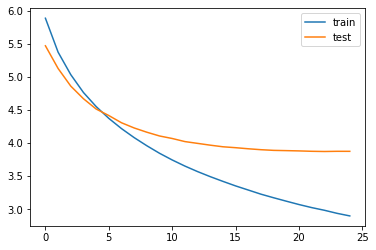

In [43]:
# train, test loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [44]:
# 정수 인덱스로 되어있던 텍스트 데이터를 실제 데이터로 복원하기

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [45]:
# 인퍼런스 단계에서는 인코더 모델과 디코더 모델 분리해서 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (text_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bengaluru police sunday tweeted gif appears inspired scene tv show stranger things spread awareness road safety gif highlighted message wear helmet reacting user tweeted apply part amazing social media team 
실제 요약 : bengaluru police asks people to solve on road safety 
예측 요약 :  police police to get picture of police


원문 : un general assembly unanimously passed pakistan sponsored resolution universal realisation right people self determination fundamental condition guarantee human rights resolution called states accused foreign occupation cease military intervention well acts discrimination exploitation 
실제 요약 : un assembly adopts pak resolution on self 
예측 요약 :  pakistan passes away against pakistan


원문 : per reports maharashtra minister girish mahajan nashik mayor deputy mayor several police officers attended wedding underworld dawood ibrahim relative area recently sparked controversy nashik police commissioner ravindra ordered inquiry police officers attended event 
실제 요약 : ma

In [50]:
print("원문 :", seq2text(encoder_input_test[100]))
print("실제 요약 :", seq2summary(decoder_input_test[100]))
print("예측 요약 :", decode_sequence(encoder_input_test[100].reshape(1, text_max_len)))

원문 : former england footballer alan premier league time leading goalscorer goals set world record number selfies taken three minutes clicked pictures breaking previous record one photograph per rules photographer face fully visible different person picture 
실제 요약 : pl all time leading sets selfie world record 
예측 요약 :  ex world cup sets record for most scores


## 요약 데이터에 대해서도 불용어를 제거해볼까?

In [51]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [52]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [53]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [54]:
clean_headline = []

# 전체 Summary 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s))

clean_headline[:5]

['upgrad learner switches career ml al salary hike',
 'delhi techie wins free food swiggy one year cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'known hirani yrs metoo claims true sonam']

In [55]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.097763318422125
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.136213908092721


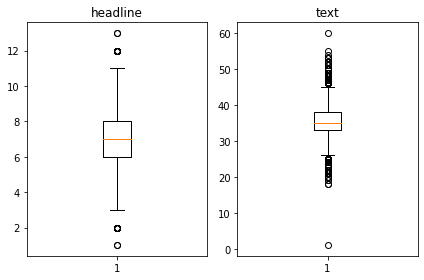

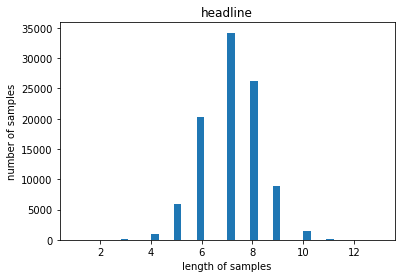

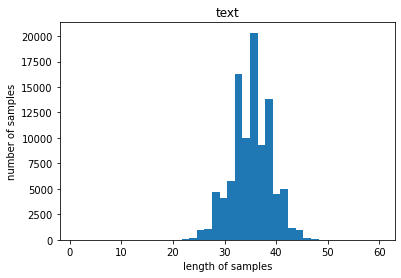

In [56]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [57]:
text_max_len = 38
headline_max_len = 9

In [58]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8164497763318422
전체 샘플 중 길이가 9 이하인 샘플의 비율: 0.9826250508336722


In [59]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 79255


In [60]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가.

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice smu...
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
7,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...


In [61]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [62]:
# 훈련 데이터 테스트 데이터 분리

indices = np.arange(encoder_input.shape[0])  # encoder_input과 크기와 형태가 같은 정수 시퀀스 생성
np.random.shuffle(indices)                   # 순서를 랜덤하게 섞어줍니다
print(indices) # 랜덤한 정수 시퀀스 생성!

[43506 41322 66874 ... 15492  8694 13624]


In [63]:
# 샘플 순서를 랜덤 시퀀스를 이용해서 정의해줌

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [64]:
# 8:2로 훈련셋 테스트셋 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15851


In [65]:
# 테스트 데이터의 갯수를 이용해 전체 데이터를 양분해줌

encoder_input_train = encoder_input[:-n_of_val] # 뒤로 n_of_val개 빼고 나머지
decoder_input_train = decoder_input[:-n_of_val] 
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] # 앞에 n_of_val개 빼고 나머지
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 : ', len(encoder_input_train))
print('훈련 레이블의 개수 : ', len(decoder_input_train))
print('테스트 데이터의 개수 : ', len(encoder_input_test))
print('테스트 데이터의 개수 : ', len(decoder_input_test))

훈련 데이터의 개수 :  63404
훈련 레이블의 개수 :  63404
테스트 데이터의 개수 :  15851
테스트 데이터의 개수 :  15851


In [66]:
src_tokenizer = Tokenizer()    # 토크나이저 생성 - 입력된 훈련 데이터로부터 단어집합 생성 가능하게 해줌
src_tokenizer.fit_on_texts(encoder_input_train)       # 입력된 데이터로부터 단어 집합 생성

In [67]:
threshold = 8
total_count = len(src_tokenizer.word_index)      # 단어의 수
rare_count = 0             # 등장 빈도수가 threshold보다 작은 단어의 개수를 count
total_freq = 0             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0              # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold) :
        rare_count = rare_count + 1
        rare_freq = rare_freq + value
        
print('단어 집합의 크기 : ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_count - rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 :  60995
등장 빈도가 7번 이하인 희귀 단어의 수: 42917
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 18078
단어 집합에서 희귀 단어의 비율: 70.36150504139684
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.378977626491785


In [68]:
src_vocab = 18000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [69]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[91, 29, 333, 162, 11, 4203, 4246, 2806, 2057, 4952, 383, 7647, 3844, 1451, 89, 12258, 2806, 775, 11, 7647, 2, 1964, 801, 110, 12259, 897, 5516, 5758, 2307, 4078, 6562, 5516, 1590, 11, 1035, 1426], [351, 407, 72, 5976, 1130, 3, 12, 256, 298, 322, 110, 416, 3769, 3605, 128, 1211, 241, 1, 615, 5, 124, 5162, 575, 5162, 3387, 99, 42, 2293, 1099, 2767], [2073, 420, 667, 138, 511, 51, 3770, 29, 36, 200, 449, 188, 630, 2034, 133, 11419, 6, 36, 164, 126, 1270, 449, 1297, 869, 294, 1176, 659, 1048, 456, 6050, 2308, 5297, 7934, 320]]


In [70]:
# headlines 에도 동일한 작업해주기
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [71]:
threshold = 8
total_count = len(tar_tokenizer.word_index)      # 단어의 수
rare_count = 0             # 등장 빈도수가 threshold보다 작은 단어의 개수를 count
total_freq = 0             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0              # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold) :
        rare_count = rare_count + 1
        rare_freq = rare_freq + value
        
print('단어 집합의 크기 : ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_count - rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 :  27048
등장 빈도가 7번 이하인 희귀 단어의 수: 19476
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 7572
단어 집합에서 희귀 단어의 비율: 72.0053238686779
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.720178148460988


In [72]:
tar_vocab = 7500
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [73]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1275, 6588, 1449, 615, 779, 6172], [1, 265, 260, 1363, 130, 137, 3071, 129], [1, 387, 65, 823, 58, 76, 187, 67, 497, 4052], [1, 630, 4, 464, 94], [1, 2681, 382, 683, 5804, 779]]
target
decoder  [[1275, 6588, 1449, 615, 779, 6172, 2], [265, 260, 1363, 130, 137, 3071, 129, 2], [387, 65, 823, 58, 76, 187, 67, 497, 4052, 2], [630, 4, 464, 94, 2], [2681, 382, 683, 5804, 779, 2]]


In [74]:
# headline의 길이가 1인 경우(실제로는 길이가 0)의 인덱스를 저장해보자
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 4
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 63400
훈련 레이블의 개수 : 63400
테스트 데이터의 개수 : 15849
테스트 레이블의 개수 : 15849


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [75]:
# post padding. 뒤의 공간에 숫자 0을 넣어준다
# 아까 지정해주었던 최대 길이로 패딩.
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='post')

In [76]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout = 0.4 )
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h, state_c= encoder_lstm3(encoder_output2)

# 인코더의 LSTM 4
encoder_lstm4 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3)

In [77]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [78]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 128)      2304000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 38, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 38, 256), (N 525312      lstm_4[0][0]                     
____________________________________________________________________________________________

In [79]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 128)      2304000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 38, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 38, 256), (N 525312      lstm_4[0][0]                     
____________________________________________________________________________________________

In [80]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
248/248 [==============================] - 178s 678ms/step - loss: 5.8673 - val_loss: 5.4875
Epoch 2/50
248/248 [==============================] - 167s 674ms/step - loss: 5.3744 - val_loss: 5.1220
Epoch 3/50
248/248 [==============================] - 167s 673ms/step - loss: 5.0511 - val_loss: 4.8858
Epoch 4/50
248/248 [==============================] - 166s 670ms/step - loss: 4.8026 - val_loss: 4.7057
Epoch 5/50
248/248 [==============================] - 164s 661ms/step - loss: 4.5889 - val_loss: 4.5392
Epoch 6/50
248/248 [==============================] - 165s 663ms/step - loss: 4.4034 - val_loss: 4.4395
Epoch 7/50
248/248 [==============================] - 164s 661ms/step - loss: 4.2456 - val_loss: 4.3440
Epoch 8/50
248/248 [==============================] - 163s 659ms/step - loss: 4.1085 - val_loss: 4.2688
Epoch 9/50
248/248 [==============================] - 164s 661ms/step - loss: 3.9841 - val_loss: 4.2095
Epoch 10/50
248/248 [==============================] - 163s 659m

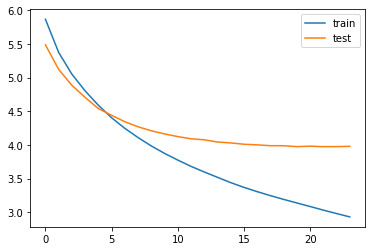

In [81]:
# train, test loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [82]:
# 정수 인덱스로 되어있던 텍스트 데이터를 실제 데이터로 복원하기

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [83]:
# 인퍼런스 단계에서는 인코더 모델과 디코더 모델 분리해서 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [84]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [85]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    print("예측 헤드라인 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former sprinter eight time olympic champion usain bolt sunday took twitter announce signed football club metre world record holder added reveal name team tuesday last year bolt lifelong manchester united fan said lot clubs reached 
실제 헤드라인 : signed football team usain bolt 
예측 헤드라인 :  usain bolt player retires record


원문 : bombay high court recently dismissed man plea divorce allegations wife cook sufficient food spend quality time also alleged wife would abuse tried wake early morning bench observed allegations made amount cruelty 
실제 헤드라인 : mumbai man seeks divorce wife cook food 
예측 헤드라인 :  hc wife divorce man filing divorce


원문 : egyptian lawyer sentenced three years jail saying raping harassing girls wearing revealing clothing national duty lawyer made remarks tv panel show october debate draft law prostitution also fined egyptian pounds 
실제 헤드라인 : egypt lawyer jailed calling rape women wear jeans 
예측 헤드라인 :  jailed yrs jail


원문 : us navy destroyer stationed coast hawaii t

In [86]:
print("원문 :", seq2text(encoder_input_test[100]))
print("실제 요약 :", seq2summary(decoder_input_test[100]))
print("예측 요약 :", decode_sequence(encoder_input_test[100].reshape(1, text_max_len)))

원문 : ipl chairman rajeev shukla confirmed remaining matches scheduled chennai shifted due cauvery protests tamil nadu shukla said initially decided host matches chennai police assured adequate security would provided police informed csk would able provide security added 
실제 요약 : ipl matches shifted chennai 
예측 요약 :  ipl plant delhi govt


## 5. Summa을 이용해서 추출적 요약해보기

In [87]:
import requests
from summa.summarizer import summarize

In [88]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [89]:
text = data['text']
text[0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [90]:
print('Summary:')
print(summarize(text[0], words=5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [91]:
# 리스트로 출력결과 받기
print('Summary:')
print(summarize(text[0], ratio=0.4, split=True))

Summary:
["upGrad's Online Power Learning has powered 3 lakh+ careers."]


In [92]:
headlines = []
for i in range(len(text)):
    headline = summarize(text[i], ratio=0.4)
    headlines.append(headline)

In [93]:
headlines[:5]

["upGrad's Online Power Learning has powered 3 lakh+ careers.",
 'Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.',
 'The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.',
 'Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.',
 'Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I\'ve known Hirani for many years...What if it\'s not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman.']

In [94]:
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 헤드라인 :", data['headlines'][i])
    print("예측 헤드라인 :", headlines[i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 헤드라인 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 헤드라인 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인 : Delhi techie wins free food from Swiggy for one year on CRED
예측 헤드라인 : Users get one CRED coin per rupee of 

## [결과 및 회고]

이번 프로젝트에서는 어텐션 모델을 활용하여 뉴스 텍스트를 추상적으로 요약해보았습니다.    
처음에는 아예 말도 안되는 문장들이 나오기도 했다가, max len과 단어집합의 크기를 조정하면서 어느 정도 실제 헤드라인과 얼추 비슷한 단어들을 포함한 문장을 뽑아낼 수 있었습니다. 그렇지만 아무리 조정해도 공통적으로 발견되는 문제점이 있었는데

1. 똑같은 단어를 2번 정도 중복해서 뽑아낼 때가 있다.
2. 그러다보니 문장이 맺어지지 않고 중간에서 끊기기도 한다.
3. 문법적으로 어색한 문장이 있다.

였습니다. 어텐션 모델의 성능을 올리기 위해 LSTM 층을 하나 더 추가하거나 헤드라인에서도 불용어를 제거해주기도 했습니다. 헤드라인에서 불용어를 제거하지 않고 요약봇을 만든 것과 제거하고 요약봇을 만든 것을 비교해보면, 제 생각에는 헤드라인에서도 불용어를 제거한 것이 더 좋은 결과를 나타냈다고 생각합니다.   
또한 Summa를 이용한 추출적 요약도 시도했는데, 뉴스 원문 자체가 길지 않아 정확한 헤드라인을 뽑아낸다고 보기는 어려운 것 같습니다. ratio나 words를 변경하면서 살펴봤는데,
1. 값을 적게 주면 아예 헤드라인을 뽑아내지 못하였고,   
2. 큰 값을 주면 문장 전체를 통째로 뽑아내버려서 유의미한 요약이 아니었습니다.   

그렇지만 그만큼 추상적 요약보다는 문법적으로 어색하지 않고 중복되는 단어를 가지지 않는 헤드라인을 만들 수 있었습니다.   


